# Importing Stuff

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML
import os

# Setting constants

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3

# Creating tf.dataset

In [3]:
peach_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "D:\College Stuff\TY\ML\MP\Dataset\Peach",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2657 files belonging to 2 classes.


In [4]:
class_names = peach_dataset.class_names
class_names

['Bacterial_spot', 'Healthy']

In [5]:
len(peach_dataset)

84

In [6]:
for image_batch, labels_batch in peach_dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]


# Dataset Visualization

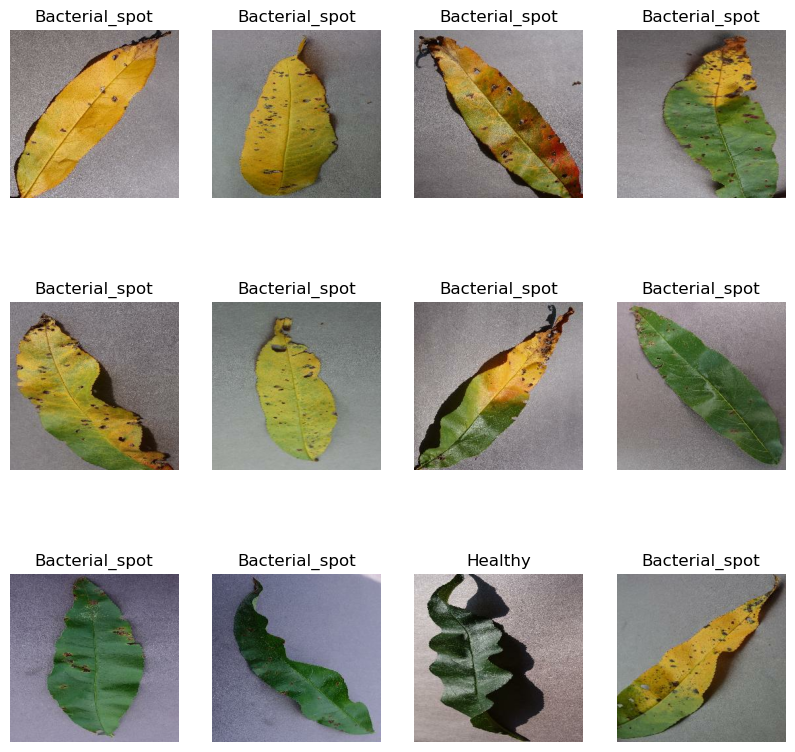

In [7]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in peach_dataset.take(5):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

# Train-Test Split

In [8]:
len(peach_dataset)

84

In [9]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=False):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [10]:
peach_train, peach_val, peach_test = get_dataset_partitions_tf(peach_dataset)

In [11]:
len(peach_dataset), len(peach_train), len(peach_val), len(peach_test)

(84, 67, 8, 9)

### Cache Suffle Prefetch

In [12]:
train_ds = peach_train.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = peach_val.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = peach_test.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

Resizing, Rescaling

In [13]:
resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
])

In [14]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [15]:
peach_train = peach_train.map(
    lambda x, y: (data_augmentation(x, training=True), y)
)

In [16]:
peach_train = peach_train.map(
    lambda x, y: (resize_and_rescale(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

Model: CNN

In [17]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 1

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='sigmoid'),
])

model.build(input_shape=input_shape)

In [18]:
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

### Compiling the model

In [19]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [20]:
class TrainingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = {}):
        if logs.get('accuracy') > 0.99:
            print('The model has reached the accuracy desired (0.99), stop the training!')
            self.model.stop_training = True

In [21]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=30,
    callbacks = TrainingCallback()
)

Epoch 1/30
67/67 [==============================] - 155s 2s/step - loss: 0.2839 - accuracy: 0.8811 - val_loss: 0.1087 - val_accuracy: 0.9570
Epoch 2/30
67/67 [==============================] - 126s 2s/step - loss: 0.1608 - accuracy: 0.9305 - val_loss: 0.1297 - val_accuracy: 0.9492
Epoch 3/30
67/67 [==============================] - 112s 2s/step - loss: 0.1002 - accuracy: 0.9571 - val_loss: 0.0600 - val_accuracy: 0.9727
Epoch 4/30
67/67 [==============================] - 116s 2s/step - loss: 0.0655 - accuracy: 0.9748 - val_loss: 0.0957 - val_accuracy: 0.9570
Epoch 5/30
67/67 [==============================] - 112s 2s/step - loss: 0.0640 - accuracy: 0.9762 - val_loss: 0.0433 - val_accuracy: 0.9805
Epoch 6/30
67/67 [==============================] - 107s 2s/step - loss: 0.0667 - accuracy: 0.9785 - val_loss: 0.0483 - val_accuracy: 0.9922
Epoch 7/30
67/67 [==============================] - 114s 2s/step - loss: 0.1009 - accuracy: 0.9580 - val_loss: 0.0399 - val_accuracy: 0.9922
Epoch 8/30
67

In [22]:
scores = model.evaluate(test_ds)

9/9 [==============================] - 6s 293ms/step - loss: 0.0183 - accuracy: 0.9961


In [23]:
scores

[0.018331406638026237, 0.9961089491844177]

Accuracy and Loss Curves

In [24]:
history

In [25]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 67}

In [26]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [27]:
epochs_trained = len(history.history['loss'])

In [28]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.28389960527420044,
 0.1607924997806549,
 0.10024604201316833,
 0.06550996750593185,
 0.0640258714556694]

In [29]:
for key in history.history:
    last_value = history.history[key][-1]
    print(key, ":", last_value)

loss : 0.026501765474677086
accuracy : 0.9934701323509216
val_loss : 0.01248166710138321
val_accuracy : 0.99609375


In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

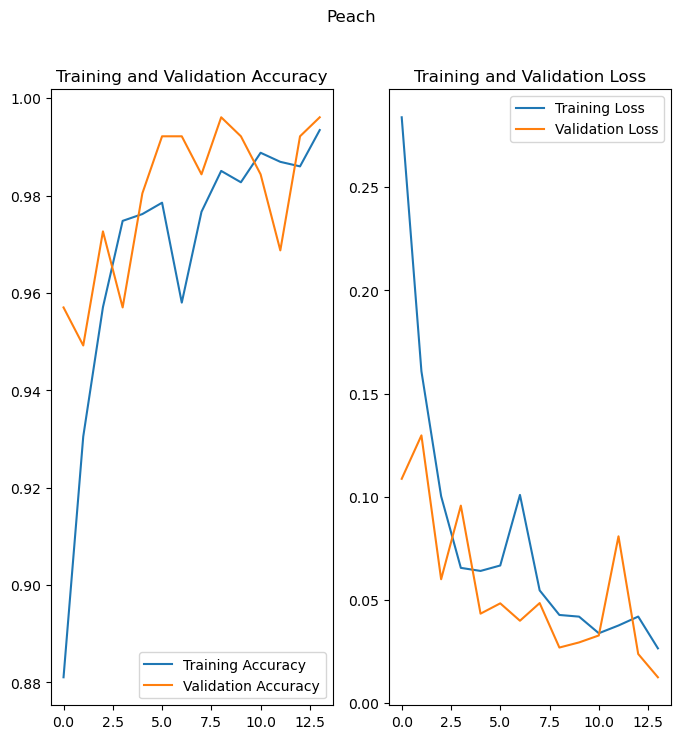

In [31]:
plt.figure(figsize=(8, 8))
plt.suptitle("Peach")
plt.subplot(1, 2, 1)
plt.plot(range(epochs_trained), acc, label='Training Accuracy')
plt.plot(range(epochs_trained), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(epochs_trained), loss, label='Training Loss')
plt.plot(range(epochs_trained), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Bacterial_spot
1/1 [==============================] - 1s 858ms/step
predicted label: Bacterial_spot


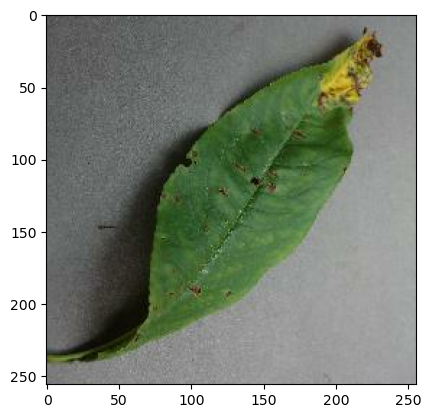

In [32]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [48]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 - (100 * (np.max(predictions[0]))), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 42ms/step


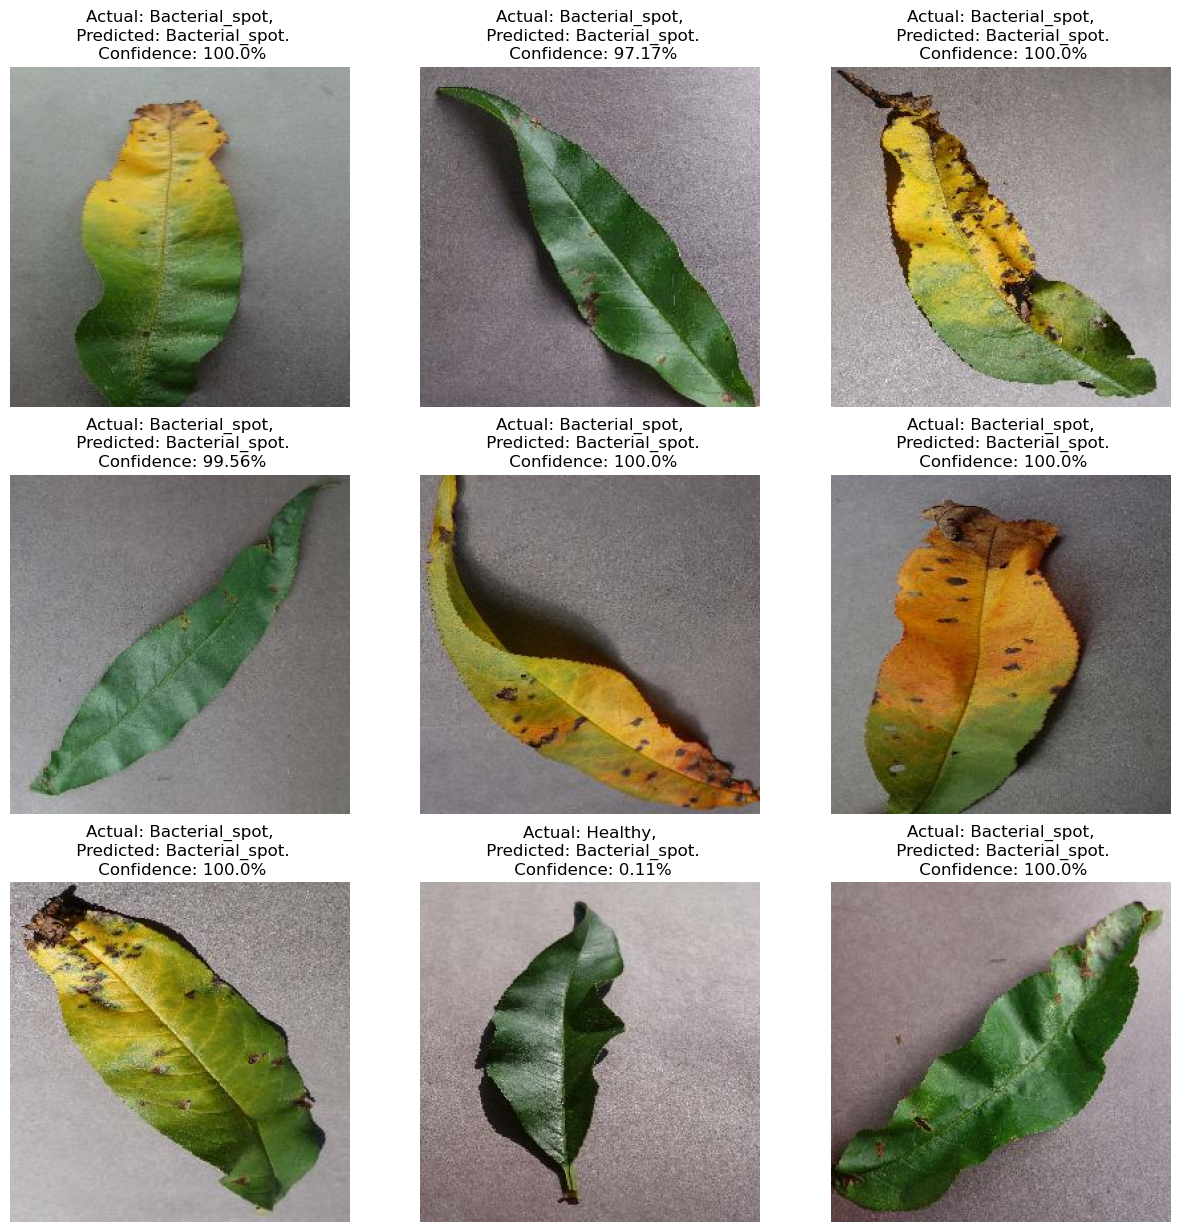

In [49]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [35]:
model.save(r'D:\College Stuff\TY\ML\MP\Main\Models\peach_cnn.h5')

In [36]:
import os
model.save("D:\College Stuff\TY\ML\MP\Main\Models\Peach")

INFO:tensorflow:Assets written to: D:\College Stuff\TY\ML\MP\Main\Models\Peach\assets


INFO:tensorflow:Assets written to: D:\College Stuff\TY\ML\MP\Main\Models\Peach\assets


In [37]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_ds:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

1/1 [==============================] - 0s 317ms/step


In [38]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

Text(0.5, 1.0, 'Peach')

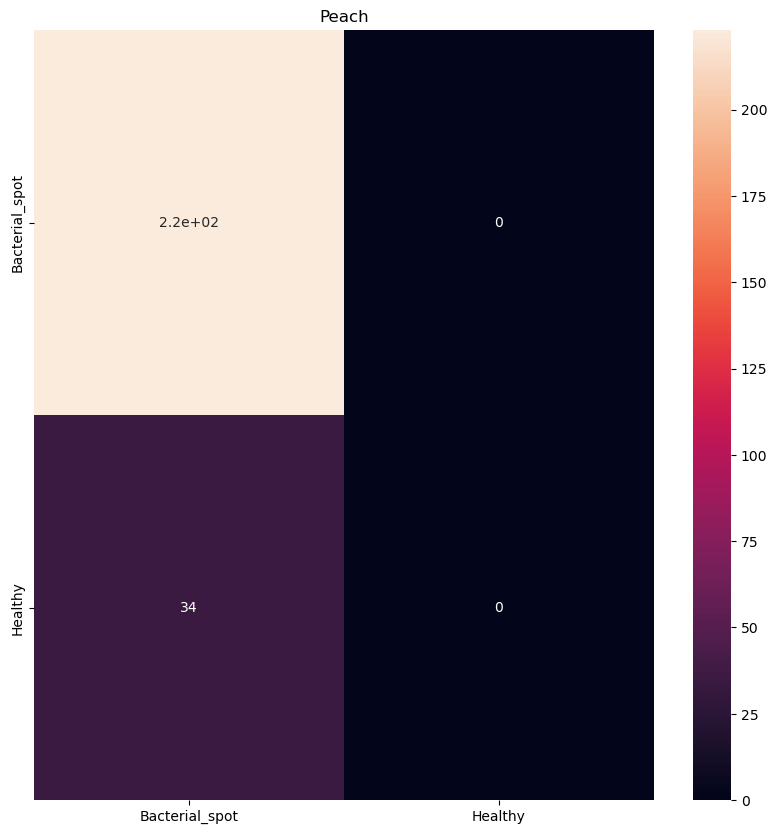

In [39]:
plt.figure(figsize=(10, 10))
peach_cm = confusion_matrix(y_true=correct_labels, y_pred=predicted_labels)
graph_labels = ['Bacterial_spot', 'Healthy']
sns.heatmap(peach_cm, annot = True, xticklabels=graph_labels, yticklabels=graph_labels)
plt.title("Peach")

In [40]:
from sklearn.metrics import roc_curve
def make_roc_curve(fpr1,tpr1,p_fpr,p_tpr, title):

    plt.plot(fpr1, tpr1, linestyle='--',color='orange')
    plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
    # title
    plt.title(title)
    # x label
    plt.xlabel('False Positive Rate')
    # y label
    plt.ylabel('True Positive rate')

    plt.legend(loc='best')
    plt.show()

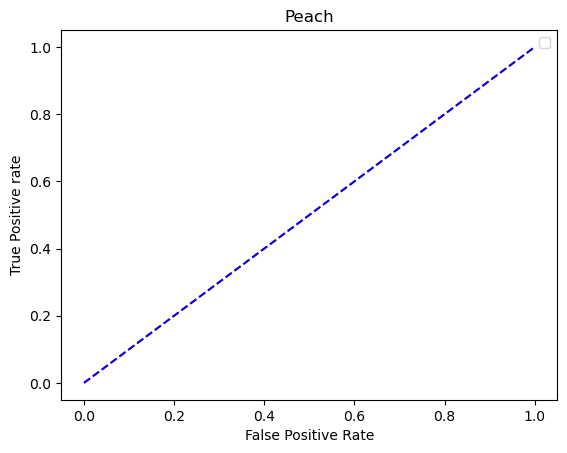

In [41]:
fpr1, tpr1, thresh1 = roc_curve(correct_labels, predicted_labels, pos_label=1)
random_probs = [0 for i in range(len(correct_labels))]
p_fpr, p_tpr, _ = roc_curve(correct_labels, random_probs, pos_label=1)

make_roc_curve(fpr1,tpr1,p_fpr,p_tpr, title = "Peach")